# Modeling Student Results in Course Networks

This notebook contains example code of how to the Modeling described in Haas, Caprani & Van Beurden. First, the idealized experiments are repeated (and there are models shown here than in the paper). After that, the Open University data set is decribed briefly and modeled. The data set of the Amsterdam College of Law is not public and will not be shown here, but the procedure is analogous to the other examples.

## Idealized experiments

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm

from bgm_course_networks import create_data, grade_df, course_network, show_course_network

In [ ]:
# Create a list of grades for n_st students
n_st = 500
grades = create_data(n_st=n_st)
# Set to NaN for those who didn't do some courses:
grades[n_st:,:3] = np.nan
grades[:n_st,4:] = np.nan


plt.hist(grades.flatten(), bins=np.arange(6,10,.1));
plt.title("Distribution of all grades");

In [ ]:
# Model it and visualize results
trace, sim = model_and_visualize(cijfertjes)

In [ ]:
# The computational graph of the model
model_pic = pm.model_graph.model_to_graphviz(sim)
model_pic

## Experimenting with different ingredients

1. Increasing the noise on grades

In [ ]:
n_st = 500
grades = create_data(n_st=n_st, noise_grades=0.7)
# Set to NaN for those who didn't do some courses:
grades[n_st:,:3] = np.nan
grades[:n_st,4:] = np.nan
# to df
scatter_grades = grade_df(grades)
# Model
trace_scatter_grades, sim_scatter_grades = model_and_visualize(cijfertjes_scatter_grades)

2. Decrease the fraction of people doing the linking course (still with some scatter on noise)

In [ ]:
f_link = 0.1
n_st = 500
grades = create_data(n_st=n_st, noise_cijfers=.5)
# Set to NaN for those who didn't do some courses:
grades[n_st:,:3] = np.nan
grades[:n_st,4:] = np.nan
# Remove a bunch of people from the link course
ind_remove = np.random.choice(np.arange(2*n_st), size=int(2*n_st*(1-f_link)), replace=False)
grades[ind_remove,3] = np.nan 
# to df
grades_overlap = grade_df(grades)
# Model
trace_overlap, sim_overlap = model_and_visualize(cijfertjes_overlap)

## The Open Univeristy data set

The data is downloaded from the [Open University](https://analyse.kmi.open.ac.uk/open_dataset) and contains information on students, modules, presentation and assessments. There is lots more information than is used here. This Exploration only focuses on aspects of the data used in the study.

The image below comes directly from the above website and shows the DB relation structure.

<img src=https://analyse.kmi.open.ac.uk/resources/images/model.png>

We will focus on studentAssessment results of the "Exam" type. The code assumes that the data is stored in a 'data/' folder in the working directory. This folder is not included in the repository.

In [2]:
datapath = 'data/'
all_results = pd.read_csv(datapath+'studentAssessment.csv')
assessments = pd.read_csv(datapath+'assessments.csv')

In [3]:
print(all_results.shape)
all_results.head()

(173912, 5)


,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [4]:
print(assessments.shape)
assessments.tail()

(206, 6)


,code_module,code_presentation,id_assessment,assessment_type,date,weight
201,GGG,2014J,37443,CMA,229.0,0.0
202,GGG,2014J,37435,TMA,61.0,0.0
203,GGG,2014J,37436,TMA,124.0,0.0
204,GGG,2014J,37437,TMA,173.0,0.0
205,GGG,2014J,37444,Exam,229.0,100.0


From the website: code presentation with yyyy(J/B) are separate presentations that may differ in structure, so it may be wise to see one "course" as `code_module`+`code_presentation`. For now, though, I will just use code_module, as that is supposedly the same educational content, just given at another time, in a slightly different structure. We are interested in final grades, which are calculated as follows: the weights of all grades for assessments (other than Exam) add up to 100%, and the Exam has weight 100% as well. The website says nothing about how the grade of a course is calculated, so we will assume it is the average of exam and assessments, if both exist.

In [5]:
# assessments['course'] = assessments.code_module + assessments.code_presentation
assessments['course'] = assessments.code_module
exams = assessments[assessments.assessment_type == "Exam"]
assessments = assessments[assessments.assessment_type != "Exam"]
print(f'That leaves us with {assessments.shape[0]} assessments and {exams.shape[0]} exams')

That leaves us with 182 assessments and 24 exams


In [6]:
results = all_results.merge(exams, how='inner', on='id_assessment')#[['id_student', 'course', 'score', 'assessment_type']]
results_assessments = all_results.merge(assessments, how='inner', on='id_assessment')

In [7]:
print(results.shape)
results.head()

(4959, 11)


,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,course
0,24290,558914,230,0,32.0,CCC,2014B,Exam,NaN,100.0,CCC
1,24290,559706,234,0,78.0,CCC,2014B,Exam,NaN,100.0,CCC
2,24290,559770,230,0,54.0,CCC,2014B,Exam,NaN,100.0,CCC
3,24290,560114,230,0,64.0,CCC,2014B,Exam,NaN,100.0,CCC
4,24290,560311,234,0,100.0,CCC,2014B,Exam,NaN,100.0,CCC


So, added up, per student, per code_module, the weights should be one hundred for all non-exams. Apparently, not everyone handed in everything.

In [8]:
results_assessments["frac_score"] = results_assessments.weight * results_assessments.score

pcps_weightedscore = results_assessments.groupby(['code_module', 'id_student']).frac_score.sum() / results_assessments.groupby(['code_module', 'id_student']).weight.sum()

pcps = pd.DataFrame(pcps_weightedscore).reset_index().rename(columns={0:'score'})
pcps.head()

,code_module,id_student,score
0,AAA,6516,63.5
1,AAA,11391,82.4
2,AAA,24734,47.5
3,AAA,26192,86.3
4,AAA,28061,77.4


### There are only exams of students for coursed CCC and DDD, while IDs exist for all...

Instead, let's go for exams for a course and assessments for a course as separate course results!

In [9]:
pcps['code_module'] = pcps.code_module + '_a'
student_results = pd.concat([results[['code_module', 'id_student', 'score']], pcps], axis=0).dropna().rename(
    columns={'id_student':'StudentNumber', 'code_module':'Course', 'score':'Grade'})

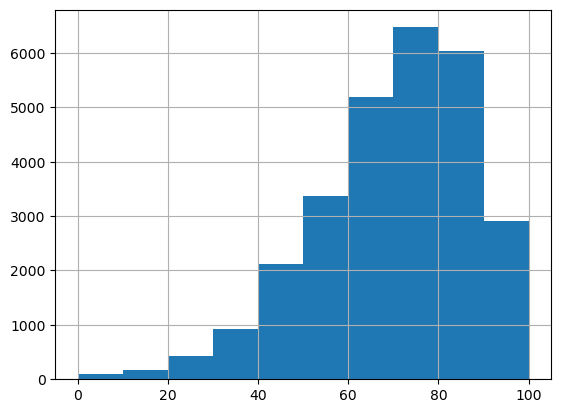

In [10]:
student_results.Grade.hist();

Let's see if a network can be built out of this. Useless data, almost all students are unique, no overlapping groups.

In [11]:
import networkx as nx

def nudge(pos, x_shift, y_shift):
    return {n:(x + x_shift, y + y_shift) for n,(x,y) in pos.items()}


def show_course_network(course_net, use_metadata=True, kind='spring'):
    """Simple graph plotting function, just to save spcae in the notebook.
    
    Takes a graph and uses some pre-defined metadata to plot a network.    
    """
    
    
    # Aux variables for plot normalisation
    nodes_data = np.array([v[1]['nstudents'] for v in course_net.nodes.data()] )
    min_ns, max_ns = nodes_data.min(), nodes_data.max()
    edges_data = np.array([v[2]['nstudents'] for v in course_net.edges.data()] )
    min_no, max_no = edges_data.min(), edges_data.max()
    
    fig, ax = plt.subplots(figsize=(10, 8))
    if kind == 'spring':
        pos = nx.spring_layout(course_net, k=0.7, seed=42) 
    elif kind == 'shell':
        pos = nx.shell_layout(course_net, )
    elif kind == 'spiral':
        pos = nx.spiral_layout(course_net)
    elif kind == 'spectral':
        pos = nx.spectral_layout(course_net)
    elif kind == "kamada_kawai":
        pos = nx.kamada_kawai_layout(course_net)
    elif kind == "planar":
        pos = nx.planar_layout(course_net)
    else:
        print("Kind of graph not recognized; known: (spring, shell," 
              "spiral, spectral, kamada_kawai, planar), exiting...")
        return
    try:
        node_size = [(v[1]['nstudents']-min_ns+1)*5000/(max_ns - min_ns) for v in course_net.nodes.data()]
        node_color = [v[1]['avgrade'] for v in course_net.nodes.data()]
        widths = [3*(v[2]['nstudents']-min_no)/(max_no - min_no)+.1 for v in course_net.edges.data()]

        pos = nx.spring_layout(course_net)
        pos_nodes = nudge(pos, 0, 0.1)                              # shift the layout

        nx.draw_networkx(
            course_net,
            pos=pos,
            with_labels=False,
            node_color=node_color,
            node_size=node_size,
            edge_color="black",
            width=widths,
            cmap='viridis',
            alpha=0.7
        )
        nx.draw_networkx_labels(course_net, pos=pos, font_color='black')
        # font = {"color": "r", "fontweight": "bold", "fontsize": 14}
        # plt.title(f"Node size correpsonds to number of students, color to average grade, edge thickness to overlap.", fontdict=font)
        # plt.xlabel(f"{nx.number_connected_components(course_net)} separate connected subgraphs", fontdict=font)
        sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min(node_color), vmax=max(node_color)))
        sm.set_array([])
        cbar = plt.colorbar(sm)
        cbar.ax.set_ylabel('Mean Grade', fontsize=14)
        
    except Exception as inst:
        print(type(inst)) 


C:\Users\mrhaas\AppData\Local\Temp\ipykernel_11028\3696587702.py:62: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


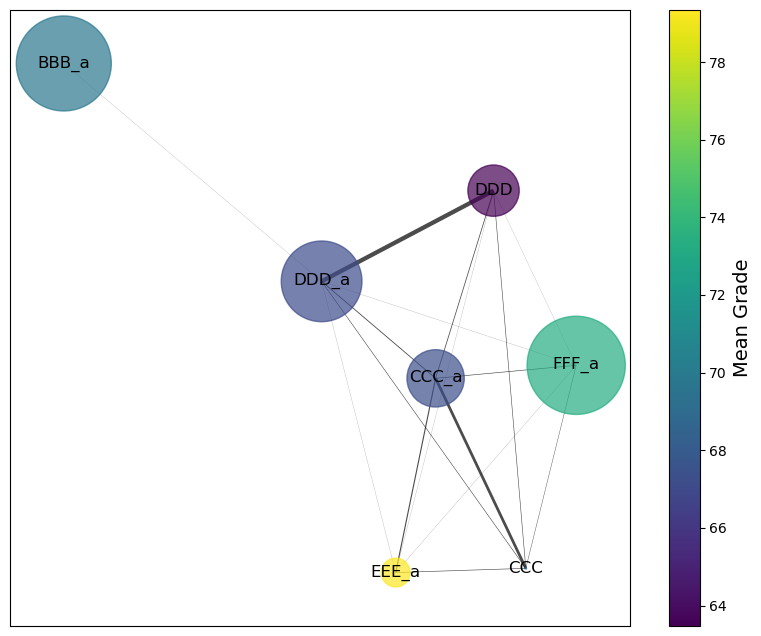

In [12]:
# from bgm_course_networks import course_network, show_course_network
nw = course_network(student_results,
                   min_students_course=10,
                   min_students_overlap=5)
show_course_network(nw, kind="spring")
# plt.savefig('figures/network_OU.png')

In [13]:
results_network = student_results[student_results.Course.isin(list(nw.nodes))]
print(f'There are {len(np.unique(results_network.StudentNumber))} students')

There are 20424 students


In [14]:
# Mean and std of grades, number of students
results_network.groupby('Course').agg({'Grade':['mean', 'std', 'count']})

Grade                 
             mean        std count
Course                            
BBB_a   69.732813  12.840143  5769
CCC     68.911749  22.707859  1915
CCC_a   67.283228  23.331187  3318
DDD     63.472405  18.821687  3044
DDD_a   67.102553  17.339764  4696
EEE_a   79.339998  13.432690  2268
FFF_a   73.209445  14.717142  6033

In [15]:
for_sns = results_network.drop_duplicates(subset=['StudentNumber', 'Course']).pivot(index='StudentNumber', columns='Course', values='Grade')
for_sns.head()

Course,BBB_a,CCC,CCC_a,DDD,DDD_a,EEE_a,FFF_a
StudentNumber,,,,,,,
8462,NaN,NaN,NaN,NaN,86.555556,NaN,NaN
23629,66.76,NaN,NaN,NaN,NaN,NaN,NaN
23698,NaN,80.0,69.97,NaN,NaN,NaN,NaN
23798,89.24,NaN,NaN,NaN,NaN,NaN,NaN
24213,NaN,NaN,NaN,58.0,78.400000,NaN,NaN


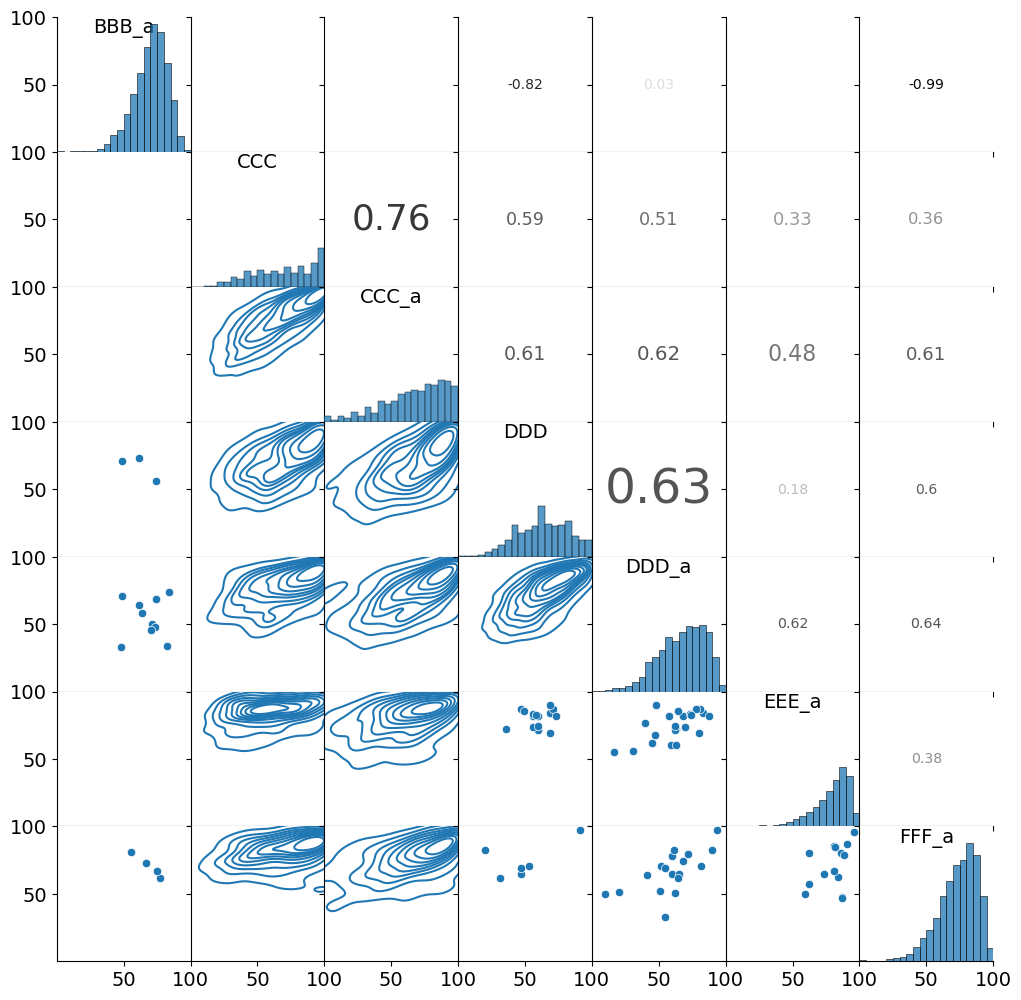

In [16]:
numbers = []
for e in nw.edges.data():
    numbers.append(e[2]['nstudents'])
nums = np.array(numbers)    
maxnum = nums.max()


def corrdot(*args, maxnum=maxnum, **kwargs):
    filt = (args[0].notna() & args[1].notna())
    corr_r = args[0][filt].corr(args[1][filt], 'pearson')
    if not corr_r < 2: return
    font_size = 25*filt.sum() / maxnum + 10
    corr_text = round(corr_r, 2)
    ax = plt.gca()
    alpha = abs(corr_r) * 9/10 + .1
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size, alpha=alpha)

    
def scatter_or_density(*args, **kwargs):
    N = (args[0].notna() & args[1].notna()).sum()
    if N < 100: return sns.scatterplot(x=args[0], y=args[1])
    else: return sns.kdeplot(x=args[0], y=args[1])

g = sns.PairGrid(for_sns)
g.fig.set_size_inches(10,10)
# g.map_lower(sns.scatterplot, alpha=0.2)
g.map_lower(scatter_or_density)
g.map_diag(sns.histplot, bins=np.arange(0,101, 5))
g.map_upper(corrdot)
g.fig.subplots_adjust(wspace=0, hspace=0)

# Remove axis labels
for ax in g.axes.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xlim(0,100)
    ax.set_ylim(0,100)
    ax.set_xticks([50,100])
    ax.set_xticklabels([50, 100], fontsize=14)
    ax.set_yticks([50,100])
    ax.set_yticklabels([50, 100], fontsize=14)    

# Add titles to the diagonal axes/subplots
for ax, col in zip(np.diag(g.axes), for_sns.columns):
    ax.set_title(col, y=0.82, fontsize=14)
# g.savefig('figures/OU_pairplot.png')

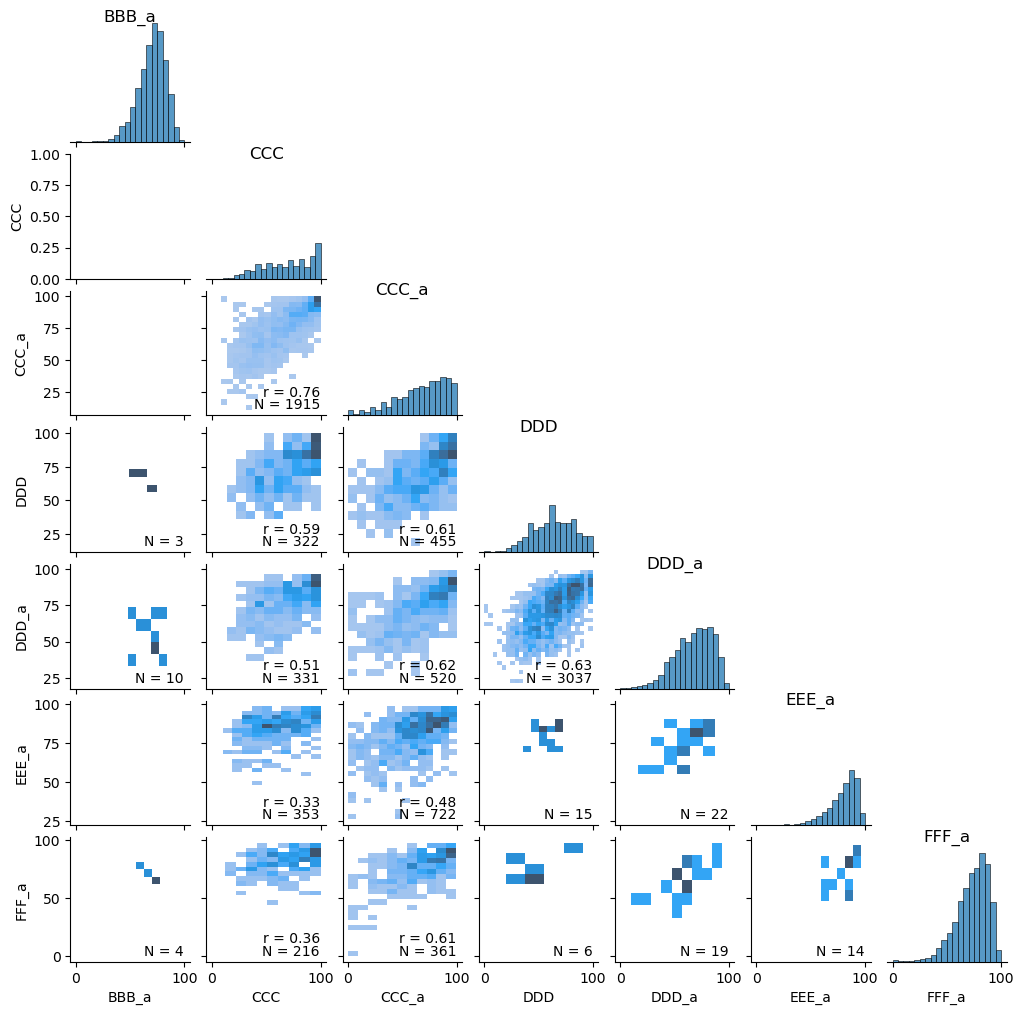

In [19]:
numbers = []
for e in nw.edges.data():
    numbers.append(e[2]['nstudents'])
nums = np.array(numbers)    
maxnum = nums.max()

from scipy.stats import pearsonr
def reg_coef(x,y,label=None,color=None,**kwargs):
    ax = plt.gca()
    try:
        filt = (x.notna() & y.notna())
        r,p = pearsonr(x[filt],y[filt])
        n = filt.sum()
        if n>30:
            ax.annotate(f'r = {r:.2f}', xy=(0.95,0.15), xycoords='axes fraction', ha='right')
        ax.annotate(f'N = {n}', xy=(0.95,0.05), xycoords='axes fraction', ha='right')
    except:
        pass

def corrdot(*args, maxnum=maxnum, **kwargs):
    filt = (args[0].notna() & args[1].notna())
    corr_r = args[0][filt].corr(args[1][filt], 'pearson')
    if not corr_r < 2: return
    font_size = 25*filt.sum() / maxnum + 10
    corr_text = round(corr_r, 2)
    ax = plt.gca()
    alpha = abs(corr_r) * 9/10 + .1
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size, alpha=alpha)

    
def scatter_or_density(*args, **kwargs):
    N = (args[0].notna() & args[1].notna()).sum()
    if N < 100: return sns.scatterplot(x=args[0], y=args[1])
    else: return sns.kdeplot(x=args[0], y=args[1])

g = sns.PairGrid(for_sns, corner=True)
g.fig.set_size_inches(10,10)
# g.map_lower(sns.scatterplot, alpha=0.2)
# g.map_lower(scatter_or_density)
g.map_lower(sns.histplot)
g.map_lower(reg_coef)

g.map_diag(sns.histplot, bins=np.arange(0,101, 5))
# g.map_upper(corrdot)
# g.fig.subplots_adjust(wspace=0, hspace=0)

# Remove axis labels
# for ax in g.axes.flatten():
#     ax.set_ylabel('')
#     ax.set_xlabel('')
#     ax.set_xlim(0,100)
#     ax.set_ylim(0,100)
#     ax.set_xticks([50,100])
#     ax.set_xticklabels([50, 100], fontsize=14)
#     ax.set_yticks([50,100])
#     ax.set_yticklabels([50, 100], fontsize=14)    

# # Add titles to the diagonal axes/subplots
for ax, col in zip(np.diag(g.axes), for_sns.columns):
    ax.set_title(col, y=0.9, fontsize=12)
g.savefig('figures/OU_pairplot_rev.png')

## Model the data set

See the paper for details on the selectino of courses.

In [ ]:
# This is another modeling function, but it's very similar
trace, sim = model_and_visualizeOU(results_network[results_network.Course.isin(['CCC_a', 'DDD', 'DDD_a'])])

In [ ]:
# Save the trace, so I don't need to run it all again tomorrow!
# import pickle
# with open('data/OUtrace_allbut_CCC_BBB_a.pkl', 'wb') as f:
#     pickle.dump(trace, f)


In [ ]:
import seaborn as sns
# Looking at student ability from the posteriors
students = az.summary(trace, var_names=["Student ability"])
sd_overall = students["mean"].std()
print(sd_overall)

sns.displot(data=students, x='sd', label='Posteriors of students')
plt.vlines(sd_overall, 0, 450, color='red', label='Means of students')
plt.xlabel('Standard deviation')
# plt.xlim([0,3.2])
plt.legend(loc='upper right');
# plt.savefig('OUstudent_ability_stds.pdf')